In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


#acciones que cotizan desde hace más de 20 años de las más famosas
tickers = ['AAPL', 'MSFT', 'IBM', 'GE', 'XOM', 'JNJ', 'WMT']
# Oro y petróleo
commodities = commodities = ['GLD', 'USO']

all_tickers = tickers + commodities

# Descarga de datos desde el año 2000
data = yf.download(all_tickers, start="2007-01-01", end="2024-12-31")['Close'] #tomasmos únicamente el cierre
data = data.dropna(how='all')  #eliminar filas completamente vacías puede ser un día que no cotizaron


[*********************100%***********************]  9 of 9 completed


Investigando un poco acerca de estos instrumentos de inversión, vi que los ETF que siguen los precios del oro empezó en 2004 y del petróleo en 2006, por lo tanto los datos se empezaran desde el 2007 hasta finales del año 2024. para evitar lo más posible las filas con NaN

In [41]:
print(data.head(10))

Ticker          AAPL          GE        GLD        IBM        JNJ       MSFT  \
Date                                                                           
2007-01-03  2.521844  115.851677  62.279999  51.826504  38.903000  21.235304   
2007-01-04  2.577818  115.180481  61.650002  52.380604  39.389290  21.199743   
2007-01-05  2.559461  114.600723  60.169998  51.906387  39.031887  21.078850   
2007-01-08  2.572099  114.570198  60.480000  52.694954  38.967438  21.285089   
2007-01-09  2.785764  114.570198  60.849998  53.318336  38.820976  21.306423   
2007-01-10  2.919079  114.600723  60.590000  52.689613  38.756519  21.093071   
2007-01-11  2.882967  115.699112  60.630001  52.561760  39.096321  21.832676   
2007-01-12  2.847457  115.607597  62.169998  52.929405  39.043594  22.195374   
2007-01-16  2.922087  116.278893  61.970001  53.717960  38.985016  22.159809   
2007-01-17  2.857387  115.882256  62.639999  53.291737  39.178364  22.117146   

Ticker             USO        WMT      

In [17]:
T = 101
N = 3000  # número de series
M = len(all_tickers)

# Imputación de valores perdidos con la media
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), index=data.index, columns=data.columns)

# Normalizar (opcional pero recomendable)
data_normalized = (data_imputed - data_imputed.mean()) / data_imputed.std()

# Crear ventanas de tamaño T
X_all = []
Y_all = []

for _ in range(N):
    idx = np.random.randint(0, len(data_normalized) - T)
    window = data_normalized.iloc[idx:idx+T].values.T  # MxT
    X_all.append(window[:, :-1])  # Mx100 que equivale a S[:T-1]
    Y_all.append(window[:, -1])   # Mx1 que equivale a S[-1]

X = np.array(X_all)  # Shape: (N, M, 100)
Y = np.array(Y_all)  # Shape: (N, M)


 Esto asegura que cada ejemplo usa 100 pasos anteriores para predecir el número 101 de cada serie.



In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, InputLayer

model = Sequential([
    InputLayer(input_shape=(M, 100)),     # (M, 100)
    tf.keras.layers.Permute((2,1)),       # (100, M)
    LSTM(64), #usamos una RNN Long short-term memory
    Dense(M)                              # Salida: (M,)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute_1 (Permute)             │ (None, 100, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,529 (76.29 KB)

 Trainable params: 19,529 (76.29 KB)

 Non-trainable params: 0 (0.00 B)

se decidió optar por una LSTM por que es de las clásicas y usa una función tanh para las de activación y sigmoide para las resurrentes por default

In [20]:
history = model.fit(X, Y, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.4497 - val_loss: 0.0325
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0242 - val_loss: 0.0148
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0132 - val_loss: 0.0109
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0

In [25]:
# Baseline: usar el último valor de la serie como predicción, es decir el precio es el mismo o no hacer nada
Y_baseline = X[:, :, -1]  # Última columna de cada serie

# Métricas de error
preds = model.predict(X)

mse_model = mean_squared_error(Y.flatten(), preds.flatten())
mse_baseline = mean_squared_error(Y.flatten(), Y_baseline.flatten())

print(f"Error MSE - Modelo LSTM: {mse_model:.4f}")
print(f"Error MSE - Baseline: {mse_baseline:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Error MSE - Modelo LSTM: 0.0029
Error MSE - Baseline: 0.0012


In [40]:
# Medias y desviaciones originales
mean = data_imputed.mean().values  # shape: (M,)
std = data_imputed.std().values    # shape: (M,)

# Desnormalizar la predicción de la primera serie
real_pred = preds[0] * std + mean

print("Predicción desnormalizada para la primera serie:")
for ticker, value in zip(all_tickers, real_pred):
    print(f"{ticker}: {value:.2f}")

Predicción desnormalizada para la n serie:
AAPL: 14.25
MSFT: 69.11
IBM: 159.73
GE: 105.96
XOM: 44.72
JNJ: 19.58
WMT: 305.67
GLD: 14.73
USO: 49.93


In [54]:
data.head(100) #ultimos valores de los datos iniciales

Ticker,AAPL,GE,GLD,IBM,JNJ,MSFT,USO,WMT,XOM
Date,,,,,,,,,
2007-01-03,2.521844,115.851677,62.279999,51.826504,38.903000,21.235304,395.200012,10.799377,39.330200
2007-01-04,2.577818,115.180481,61.650002,52.380604,39.389290,21.199743,379.119995,10.851613,38.592518
2007-01-05,2.559461,114.600723,60.169998,51.906387,39.031887,21.078850,382.640015,10.763038,38.868511
2007-01-08,2.572099,114.570198,60.480000,52.694954,38.967438,21.285089,379.920013,10.674466,38.555382
2007-01-09,2.785764,114.570198,60.849998,53.318336,38.820976,21.306423,378.399994,10.763038,38.258175
...,...,...,...,...,...,...,...,...,...
2007-05-21,3.369881,114.086739,65.669998,57.426579,37.432312,22.229929,406.559998,10.688218,44.742493
2007-05-22,3.416827,114.824844,65.199997,57.244183,37.467655,21.972185,399.359985,10.669883,44.303574
2007-05-23,3.397266,115.624344,65.540001,56.643307,37.603199,21.893446,401.359985,10.621736,44.421314


Puedo observar que los datos están alejados de la predicción

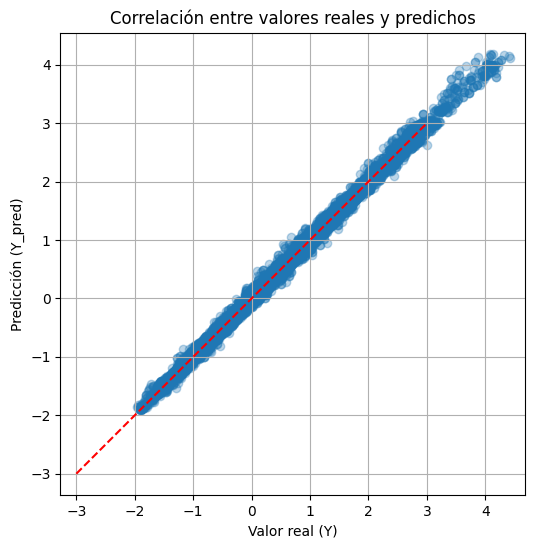

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(Y.flatten(), preds.flatten(), alpha=0.3)
plt.plot([-3, 3], [-3, 3], color='red', linestyle='--')  # Línea ideal si normalizado
plt.xlabel('Valor real (Y)')
plt.ylabel('Predicción (Y_pred)')
plt.title('Correlación entre valores reales y predichos')
plt.grid(True)
plt.axis('equal')
plt.show()


Como observamos hay una buena correlación con los datos de predicción y de los reales pero no termino de entender porqué en el dataframe difieren tanto los valores con respecto a los reales obtenidos de yahoo finance